In [1]:
from __future__ import print_function

import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
tqdm.pandas()
pd.options.display.max_colwidth = 10000

print(f"Torch: {torch.__version__}")

Torch: 2.2.2+cu121


## Settings

In [2]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [4]:
device = 'cuda'

In [5]:
base_dir = "kaggle/input/hms-harmful-brain-activity-classification"

train_df = pd.read_csv(base_dir + "/train.csv")
train_eeg_path_list = glob.glob(base_dir + "/train_eegs/*")
train_df['eeg_path'] = train_df['eeg_id'].astype(str).progress_apply(lambda x: [i for i in train_eeg_path_list if x in i][0])
train_spectrograms_path_list = glob.glob(base_dir + "/train_spectrograms/*")
train_df['spectrograms_path'] = train_df['spectrogram_id'].astype(str).progress_apply(lambda x: [i for i in train_spectrograms_path_list if x in i][0])

class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
name2label = {v:k for k, v in label2name.items()}
train_df['class_name'] = train_df.expert_consensus.copy()
train_df['class_label'] = train_df.expert_consensus.map(name2label)

  0%|          | 0/106800 [00:00<?, ?it/s]

  0%|          | 0/106800 [00:00<?, ?it/s]

In [6]:
train_valid, test_list = train_test_split(train_df, test_size=0.2, random_state=seed)
train_list, valid_list = train_test_split(train_valid, test_size=0.2, random_state=seed)

print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 68352
Validation Data: 17088
Test Data: 21360


### Parquet to NPY

In [25]:
def parquet_to_numpy(parquet_path):
    # Read the Parquet file into a DataFrame
    spec_df = pd.read_parquet(parquet_path)
    
    # Process the DataFrame to convert it into a numpy array
    spec_array = spec_df.fillna(0).values[:, 1:].T  # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec_array = np.pad(spec_array, ((0, 0), (0, max(400-spec_array.shape[1], 0))), "constant", constant_values=0)
    spec_array = spec_array.astype("float32")
    spec_array.resize((400, 400), refcheck=False)
    
    return np.expand_dims(spec_array, 0)

In [26]:
def preprocess_spectrogram(image_array):

    # Normalization: Ensures that the pixel values are within a certain range
    # This helps in stabilizing the training process and ensures faster convergence
    image_array = image_array.astype('float32')
    image_array -= np.min(image_array)
    image_array /= np.max(image_array) + 1e-4
    
    # Log Transformation: Enhances contrast and reduces the effect of outliers
    # It helps in better visualization of the spectrogram features
    image_array = np.log(image_array + 1e-4)
    
    # Mean Subtraction: Centers the data around zero
    # This helps in reducing bias and improving the stability of the model
    mean = np.mean(image_array)
    image_array -= mean
    
    # Standardization: Scales the data to have zero mean and unit variance
    # It ensures that all features are on a similar scale, which can improve model performance
    std = np.std(image_array)
    image_array /= std + 1e-6
    
    return image_array

In [27]:
spec_path = base_dir + "/test_spectrograms/853520.parquet"
spec_array = parquet_to_numpy(spec_path)
spec_array

TypeError: unsqueeze(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

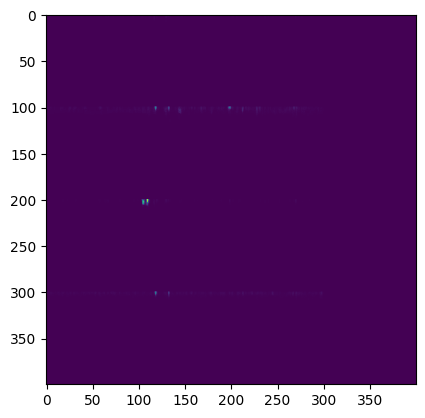

In [10]:
image_array = np.random.rand(400, 300)

preprocessed_image = preprocess_spectrogram(spec_array)

plt.imshow(spec_array)

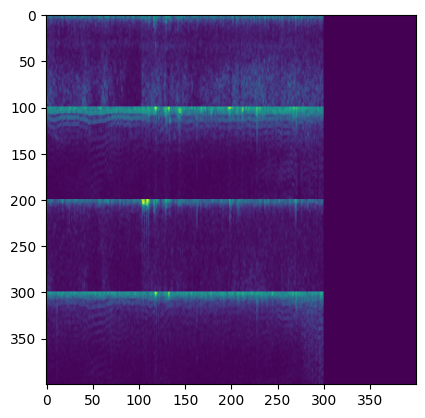

In [11]:
plt.imshow(preprocessed_image)

## Data loader

In [12]:
class HmsDataset(Dataset):
  def __init__(self, df: pd.DataFrame):
    self.__df = df
    
  
  def __len__(self):
    return self.__df.shape[0]
  
  def __getitem__(self, idx):
    val = self.__df.iloc[idx]
    spec_path = val["spectrograms_path"]
    return preprocess_spectrogram(parquet_to_numpy(spec_path)), val["class_label"]

In [13]:
train_data = HmsDataset(train_list)
valid_data = HmsDataset(valid_list)
test_data = HmsDataset(test_list)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [14]:
print(len(train_data), len(train_loader))

68352 1068


In [15]:
print(len(valid_data), len(valid_loader))

17088 267


In [16]:
print(len(test_data), len(test_loader))

21360 334


## Model

In [17]:

from cnn_model import CNN

In [18]:
model = CNN(len(class_names))
model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

# Training

In [19]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

# Test save
torch.save(model.state_dict(), f"models/cnn_test.pt")

In [21]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    torch.save(model.state_dict(), f"models/cnn_model_epoch_{epoch + 1}_val_acc_{epoch_val_accuracy:.4f}.pt")
    print(f"Saved model in models/cnn_model_epoch_{epoch + 1}_val_acc_{epoch_val_accuracy:.4f}.pt")

  0%|          | 0/1068 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [6, 1, 5, 5], expected input[1, 64, 400, 400] to have 1 channels, but got 64 channels instead

# Test

In [ ]:
test_model = ViT(
  dim=120,
  image_size=400,
  patch_size=40,
  num_classes=len(class_names),
  channels=1,
  heads=16,
  mlp_dim=2048,
  dropout=0.1,
  emb_dropout=0.1,
  depth = 6,
)

test_model.load_state_dict(torch.load("models/model_epoch_17_val_acc_0.8806.pt"))
test_model.eval()
test_model = test_model.to(device)

In [ ]:
with torch.no_grad():
  test_accuracy = 0
  test_total_loss = 0
  for data, label in tqdm(test_loader):
      data = data.to(device)
      label = label.to(device)

      test_output = test_model(data)
      test_loss = criterion(test_output, label)

      acc = (test_output.argmax(dim=1) == label).float().mean()
      test_accuracy += acc / len(test_loader)
      test_total_loss += val_loss / len(test_loader)

  print(
      f"Loss : {test_total_loss:.4f} - Accuracy: {test_accuracy:.4f}\n"
  )

  0%|          | 0/334 [00:00<?, ?it/s]

Loss : 0.3381 - Accuracy: 0.8932

